### Debugging ADNI preprocessing

In [66]:
import os
import SimpleITK as sitk
from torch.utils.data import Dataset
from collections import defaultdict
from natsort import natsorted
import numpy as np
import torch
from collections import defaultdict
from tqdm import tqdm
from IPython import display

In [70]:
### Asesssing the quality of the registrations:
registered_images_dir = "/home/s2208943/ipdis/data/ADNI_data/selected_nifti_300/"

In [71]:
ids = os.listdir(registered_images_dir)

In [72]:
os.listdir(registered_images_dir + ids[0])

['flair.nii.gz',
 't1w.nii.gz',
 't1w_registered.nii.gz',
 't1w_registered_seg.nii.gz',
 't1w_registered_pve_0.nii.gz',
 't1w_registered_pve_1.nii.gz',
 't1w_registered_pve_2.nii.gz',
 't1w_registered_pveseg.nii.gz',
 't1w_registered_mixeltype.nii.gz',
 't1w_registered_restore.nii.gz',
 't1w_registered_bias.nii.gz']

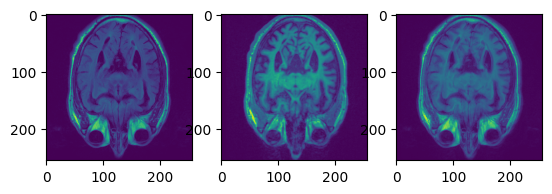

4 
 ADNI_014_S_4039_20111208


KeyboardInterrupt: Interrupted by user

In [74]:
islice=20
for i, ID in enumerate(ids):
    flair = f"{registered_images_dir}{ID}/flair.nii.gz"
    flair = sitk.GetArrayFromImage(sitk.ReadImage(flair))
    t1 = f"{registered_images_dir}{ID}/t1w_registered.nii.gz"
    t1 = sitk.GetArrayFromImage(sitk.ReadImage(t1))
    
    
    plt.subplot(1,3,1)
    plt.imshow(flair[islice])
    plt.subplot(1,3,2)
    plt.imshow(t1[islice])
    plt.subplot(1,3,3)
    plt.imshow(flair[islice] + t1[islice])
    # plt.suptitle(ID)
    plt.show()
    print(i, "\n", ID)
    input()
    display.clear_output(wait=True)

### checking that the preprocessing steps have worked

In [76]:
post_proc_folder = "/home/s2208943/ipdis/data/preprocessed_data/ADNI_300/"

In [156]:
# ID = "ADNI_002_S_0729_20110816"
# ID = "ADNI_073_S_4777_20121212"
ID = "ADNI_002_S_1155_20111222"
flair = f"{post_proc_folder}{ID}_FLAIR.nii.gz"
t1 = f"{post_proc_folder}{ID}_T1.nii.gz"
mask = f"{post_proc_folder}{ID}_FLAIR_BET_mask.nii.gz"

In [157]:
mask = sitk.GetArrayFromImage(sitk.ReadImage(mask))
flair = sitk.GetArrayFromImage(sitk.ReadImage(flair))
t1 = sitk.GetArrayFromImage(sitk.ReadImage(t1))

In [158]:
flair.shape, mask.shape

((58, 220, 220), (35, 256, 256))

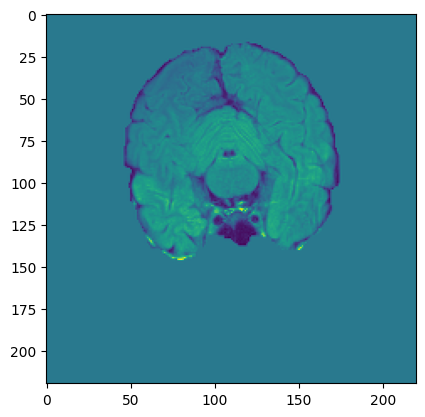

In [168]:
plt.imshow(flair[20])

### Loading all the data into one torch dataset

In [199]:
class MRI_3D_nolabels_inram_ds(Dataset):
    def __init__(self, imgs_folder, returned_filetypes=["FLAIR_BET_mask.nii.gz", "FLAIR.nii.gz", "T1.nii.gz"]):
        super().__init__()
        """
        this is a more general dataset that just assumes there is a folder
        containing images named ID_["FLAIR_BET_mask.nii.gz", "FLAIR.nii.gz", "T1.nii.gz"]
        it returns the id for each example.
        """
        # find all the relevant file names and group them by ID
        ind_files = defaultdict(lambda : {})
        files = os.listdir(imgs_folder)
        for file in files:
            for filetype in returned_filetypes:
                if filetype in file:
                    # extracting the ID from the filename: assumes all files are ID_<filetype>
                    ID = file[0:-len(filetype)-1]
                    #print(file, ID)
                    ind_files[ID][filetype] = file
                    
        # check that each individual has all filetypes
        for ID, files_map in ind_files.items():
            if len(files_map.keys()) != len(returned_filetypes):
                raise ValueError(f"not all files found for ID: {ID}")
                    
        # load all of the images into memory and stack them together
        images_lists = []
        for ID in tqdm(natsorted(list(ind_files.keys())), position=0, leave=True):
            ID_images = []
            for i, filetype in enumerate(returned_filetypes):
                ID_images.append(
                    sitk.GetArrayFromImage(
                        sitk.ReadImage(os.path.join(imgs_folder, ind_files[ID][filetype]))
                    ).astype(np.float32)
                )
            images_lists.append(ID_images)
        
        images_lists = [
            torch.from_numpy(np.stack(id_imgs)) for id_imgs in images_lists
        ]
        self.images_lists = images_lists
        
    def __getitem__(self, idx):
        return self.images_lists[idx]
    
    def __len__(self):
        return len(self.images_lists)

In [200]:
ds = MRI_3D_nolabels_inram_ds("/home/s2208943/ipdis/data/preprocessed_data/ADNI_300")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 290/290 [01:36<00:00,  2.99it/s]


In [201]:
ds[0][0].shape

torch.Size([58, 220, 220])

In [202]:
for i, data in enumerate(ds):
    for img in data:
        if img.shape != (58, 220, 220):
            print(f"index {i} failed, gave shape: ", img.shape)

index 98 failed, gave shape:  torch.Size([59, 220, 220])
index 98 failed, gave shape:  torch.Size([59, 220, 220])
index 98 failed, gave shape:  torch.Size([59, 220, 220])
index 178 failed, gave shape:  torch.Size([58, 230, 230])
index 178 failed, gave shape:  torch.Size([58, 230, 230])
index 178 failed, gave shape:  torch.Size([58, 230, 230])
index 180 failed, gave shape:  torch.Size([58, 240, 240])
index 180 failed, gave shape:  torch.Size([58, 240, 240])
index 180 failed, gave shape:  torch.Size([58, 240, 240])
index 181 failed, gave shape:  torch.Size([58, 230, 230])
index 181 failed, gave shape:  torch.Size([58, 230, 230])
index 181 failed, gave shape:  torch.Size([58, 230, 230])
index 229 failed, gave shape:  torch.Size([50, 220, 220])
index 229 failed, gave shape:  torch.Size([50, 220, 220])
index 229 failed, gave shape:  torch.Size([50, 220, 220])
index 271 failed, gave shape:  torch.Size([58, 230, 230])
index 271 failed, gave shape:  torch.Size([58, 230, 230])
index 271 failed,

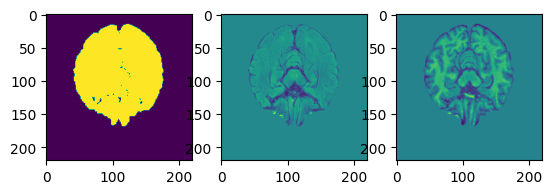

In [203]:
islice = 20
idx = 272
plt.subplot(1,3,1)
plt.imshow(ds[idx][0][islice])
plt.subplot(1,3,2)
plt.imshow(ds[idx][1][islice])
plt.subplot(1,3,3)
plt.imshow(ds[idx][2][islice])